First, construct the points where we're gonna compute the various fields.
The only nonisotropic grid is the one for the channel flow, therefore I'm generating the x and z coordinates randomly, but keeping y in check somewhat.
This shouldn't introduce any bias for the isotropic datasets.

In [1]:
import numpy as np
import pyJHTDB
from pyJHTDB.dbinfo import channel as info

npoints = 2**10
nskip = 2

p = np.random.random(
        size = (npoints, int(0.55*info['ny']/nskip)-1, 3)).astype(np.float32)
p[..., 0] *= info['lx']
p[..., 1] *= info['dy'][::nskip][None, :p.shape[1]]
p[..., 1] += info['ynodes'][::nskip][None, :p.shape[1]]
p[..., 2] *= info['lz']
print(p.shape)
time = np.random.choice(info['time'])

(1024, 139, 3)


Now I'm actually calling the database, and requesting the velocity gradient.
Afterwards, I'm averaging over the first axis of p, since the y dependency is in the second axis.

In [2]:
from pyJHTDB import libJHTDB

interp_info = [(208, 'M2Q8'),
               (214, 'M2Q14')]
divu = []
gradu = []
uval = []

lJHTDB = libJHTDB()
lJHTDB.initialize()

#Add token
auth_token  = "edu.jhu.pha.turbulence.testing-201311" #Replace with your own token here
lJHTDB.add_token(auth_token)

for ii in interp_info:
    uval.append(lJHTDB.getData(
                0.0,
                p,
                sinterp = ii[0],
                tinterp = 0,
                data_set = info['name'],
                getFunction = 'getVelocity'))
    current_gradu = lJHTDB.getData(
                0.0,
                p,
                sinterp = ii[0],
                tinterp = 0,
                data_set = info['name'],
                getFunction = 'getVelocityGradient')
    gradu.append(current_gradu)
lJHTDB.finalize()

This is the divergence error.

Text(0,0.5,'relative divergence error')

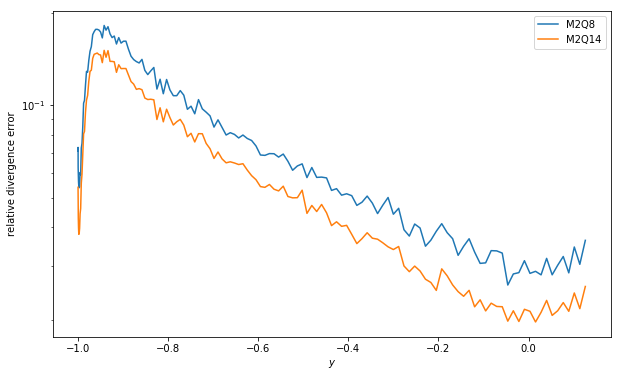

In [3]:
divu = []
for i in range(len(interp_info)):
    current_gradu = gradu[i]
    divu.append(np.sqrt(3)*
                np.average(np.abs(
                        current_gradu[..., 0] +
                        current_gradu[..., 4] +
                        current_gradu[..., 8]), axis = 0) / 
                np.average(np.sqrt(
                        current_gradu[..., 0]**2 +
                        current_gradu[..., 4]**2 +
                        current_gradu[..., 8]**2), axis = 0))
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
for i in range(len(divu)):
    ax.plot(info['ynodes'][::nskip][:divu[i].shape[0]],
            divu[i],
            label = interp_info[i][1])
ax.legend(loc = 'best')
ax.set_yscale('log')
ax.set_xlabel('$y$')
ax.set_ylabel('relative divergence error')

Now the regular error, measured by difference between the 2 successive methods.

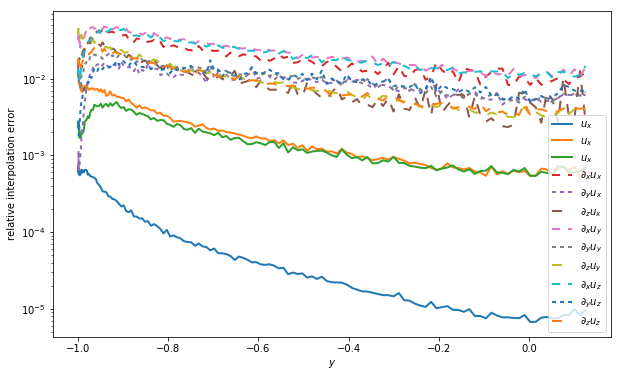

In [4]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
def plot_component_error(
        err,
        component,
        label,
        dashes = (None, None)):
    ax.plot(info['ynodes'][::nskip][:err[0].shape[1]],
            (np.average(err[0][..., component], axis = 0) /
             np.average(err[1][..., component], axis = 0)),
            label = label,
            dashes = dashes,
            linewidth = 2)

uerr  = (np.abs(uval[0] - uval[1]),
         np.abs(uval[1]))
plot_component_error(uerr, 0, '$u_x$')
plot_component_error(uerr, 1, '$u_x$')
plot_component_error(uerr, 2, '$u_x$')
duerr  = (np.abs(gradu[0] - gradu[1]),
          np.abs(gradu[1]))
plot_component_error(duerr, 0, '$\\partial_x u_x$', dashes = (4,4))
plot_component_error(duerr, 1, '$\\partial_y u_x$', dashes = (2,2))
plot_component_error(duerr, 2, '$\\partial_z u_x$', dashes = (5,5))
plot_component_error(duerr, 3, '$\\partial_x u_y$', dashes = (4,4))
plot_component_error(duerr, 4, '$\\partial_y u_y$', dashes = (2,2))
plot_component_error(duerr, 5, '$\\partial_z u_y$', dashes = (5,5))
plot_component_error(duerr, 6, '$\\partial_x u_z$', dashes = (4,4))
plot_component_error(duerr, 7, '$\\partial_y u_z$', dashes = (2,2))
plot_component_error(duerr, 8, '$\\partial_z u_z$', dashes = (5,5))
ax.legend(loc = 'best')
ax.set_yscale('log')
ax.set_xlabel('$y$')
ax.set_ylabel('relative interpolation error')
ax.legend(loc = 'best')